In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import math as mt

import fixedint as fx

In [2]:
class RNGenerator():
    def __init__(self, seed):
        if seed == 0:
            raise ValueError("Seed can't be 0!")

        self.state = fx.MutableUInt64(seed)

    def step(self):
        new_bit = (self.state ^ (self.state >> 1) ^ (self.state >> 5) ^ (self.state >> 6) ^ (self.state >> 31)) & 1
        self.state = (self.state >> 1) | (new_bit << (64 - 1))
        return new_bit

    def generate_number(self):
        number = 0
        for _ in range(64):
            number = (number << 1) | self.step()
        return number

    def simulate_uniform_rv(self):
        return self.generate_number() / 0xFFFFFFFFFFFFFFFF

    def generate_number_upper_limited(self, superior_limit):
        return (self.simulate_uniform_rv()) * superior_limit

generator = RNGenerator(0x0F0F0F0F0F0F0F0F0F)

In [3]:
# Create the RNG for the simulation
sim_generator = RNGenerator(0x123123123123123123)

In [4]:
import math

class PoissonProcess():
    def __init__(self, step_duration, pedestrian_rate, car_rate, random_seed):
        self.generator = RNGenerator(random_seed)
        self.step_duration = step_duration
    
        self.pedestrian_rate = pedestrian_rate
        self.time_till_next_pedestrian = 0
        self.car_rate = car_rate
        self.time_till_next_car = 0
    
    # Method to simulate the time between arrivals
    # Uses F^-1, the inverse of the CDF of the exponential distribution
    def simulate_time_between_events(self, rate):
        u = self.generator.simulate_uniform_rv()
        return math.log(1-u)/(-rate) 
    
    
    # Definition of the Process functions (Spawning entities)

    # [pedestrian_speed] = blocks/second
    def generate_pedestrian(self):
        random_value = self.generator.simulate_uniform_rv()
        if random_value <= 0.273:
            pedestrian_speed = 2
        elif random_value <= 0.793:
            pedestrian_speed = 3
        elif random_value <= 0.93:
            pedestrian_speed = 4
        elif random_value <= 0.978:
            pedestrian_speed = 5
        else:
            pedestrian_speed = 6
        
        #random_value = self.generator.simulate_uniform_rv()
        #if random_value <= 0.5:
        #    pedestrian_direction = LEFT
        #else:
        #    pedestrian_position = RIGHT
        return Struct("if").pack(PEDESTRIAN, pedestrian_speed)
        

    def spawn_pedestrians(self):
        if self.time_till_next_pedestrian >= self.step_duration:
            self.time_till_next_pedestrian -= self.step_duration
            return []
        else:
            pedestrians_generated = []
            time_elapsed = self.time_till_next_pedestrian
            pedestrians_generated.append(self.generate_pedestrian())
            while time_elapsed < self.step_duration:
                next_spawn_time = self.simulate_time_between_events(self.pedestrian_rate)
                time_elapsed += next_spawn_time
                if time_elapsed < self.step_duration:
                    pedestrians_generated.append(self.generate_pedestrian())
            self.time_till_next_pedestrian = time_elapsed - self.step_duration
            return pedestrians_generated
        
    def generate_car(self):
        pass

    def spawn_cars(self):
        pass

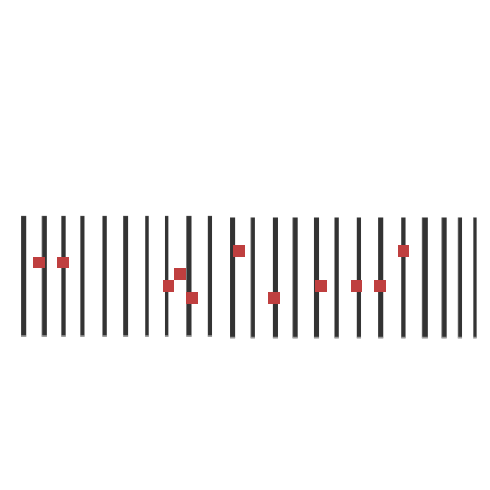

In [9]:
from struct import Struct
from queue import SimpleQueue
from threading import Thread, Lock
from PIL import Image

# Definition of matrix and general constants
EMPTY = -1
FLOOR = 0
PEDESTRIAN = 1
CAR = 2
SIDEWALK = 3

class SimulationSpace():
    def __init__(self, step_duration, dimension, amount_of_crossing_rows, sidewalk_lenght, poisson_process, random_seed):
        self.dimension = dimension
        self.poisson_process = poisson_process
        self.step_duration = step_duration

        self.generator = RNGenerator(random_seed)

        self.current_space_matrix = []
        for i in range(dimension):
            self.current_space_matrix.append([])
            for j in range(dimension):
                self.current_space_matrix[i].append(Struct("if").pack(FLOOR, 0))

        self.step_lock = Lock() #Lock for stepping with concurrency
        self.amount_of_crossing_rows = amount_of_crossing_rows
        self.sidewalk_lenght = sidewalk_lenght
        
        self.pedestrian_movement_queues = {}
        for i in range(amount_of_crossing_rows):
            self.pedestrian_movement_queues[i+int(self.dimension/2)] = SimpleQueue()

    # Matrix manipulation functions

    def distance_to_closest_neighbor(self, x_coordinate, y_coordinate):
        min_distance = EMPTY
        for j in range(self.dimension):
            if Struct("if").unpack(self.current_space_matrix[x_coordinate][j])[0] == PEDESTRIAN and j != y_coordinate:
                distance = abs(y_coordinate-j)
                if min_distance == EMPTY:
                    min_distance = distance
                else:
                    min_distance = min(min_distance, distance)
        return min_distance
    
    def generate_random_pedestrian_position(self):
        x_coordinate = int(self.dimension/2) + int(self.generator.generate_number_upper_limited(self.amount_of_crossing_rows))
        y_coordinate = int(self.generator.generate_number_upper_limited(self.sidewalk_lenght))
        return x_coordinate, y_coordinate
        
    def simulation_step(self):
        pedestrians_spawned = self.poisson_process.spawn_pedestrians()
        for pedestrian_data in pedestrians_spawned:
            x_coordinate, y_coordinate = self.generate_random_pedestrian_position()
            self.current_space_matrix[x_coordinate][y_coordinate] = pedestrian_data
        #self.update_traffic_light()
        self.pedestrian_position_step()
        #self.car_position_step()
        #self.check_crashes()


    def pedestrian_position_step(self):
        crossing_row_threads = []
        for i in range(self.amount_of_crossing_rows):
            t = Thread(target=self.pedestrian_row_step, args=[i+int(self.dimension/2)])
            t.start()
            crossing_row_threads.append(t)
        for t in crossing_row_threads:
            t.join()
        #for i in range(self.amount_of_crossing_rows):
        #    self.pedestrian_row_step(i+int(self.dimension/2))


    def pedestrian_row_step(self, row_number):
        for j in range(self.dimension):
            if Struct("if").unpack(self.current_space_matrix[row_number][j])[0] == PEDESTRIAN:
                self.handle_pedestrian_movement(row_number, j)
        self.resolve_pending_movements_in_row(row_number)


    def handle_pedestrian_movement(self, x_coordinate, y_coordinate):
        distance_to_closest_neighbor = self.distance_to_closest_neighbor(x_coordinate, y_coordinate)
        current_speed = Struct("if").unpack(self.current_space_matrix[x_coordinate][y_coordinate])[1]
        if distance_to_closest_neighbor == EMPTY:
            pedestrian_speed = current_speed
        else:
            pedestrian_speed = min(current_speed, distance_to_closest_neighbor)
        blocks_to_move = mt.ceil(pedestrian_speed*self.step_duration)

        if blocks_to_move == 0: return

        if (y_coordinate + blocks_to_move) >= self.dimension:
            self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
        else:
            self.pedestrian_movement_queues[x_coordinate].put((x_coordinate, y_coordinate, Struct("if").pack(PEDESTRIAN, pedestrian_speed), blocks_to_move))


    def resolve_pending_movements_in_row(self, row_number):
        while not self.pedestrian_movement_queues[row_number].empty():
            x_coordinate, y_coordinate, pedestrian_data, blocks_to_move = self.pedestrian_movement_queues[row_number].get()
            self.move_pedestrian(x_coordinate, y_coordinate, blocks_to_move, pedestrian_data)


    def move_pedestrian(self, old_x_coordinate, old_y_coordinate, blocks_to_move, pedestrian_data):
        self.step_lock.acquire()
        can_continue_moving = True
        current_x_coordinate, current_y_coordinate = old_x_coordinate, old_y_coordinate
        while blocks_to_move > 0 and can_continue_moving and current_y_coordinate < self.dimension-1:
            if Struct('if').unpack(self.current_space_matrix[current_x_coordinate][current_y_coordinate+1])[0] == FLOOR:
                self.current_space_matrix[current_x_coordinate][current_y_coordinate+1] = pedestrian_data
                self.current_space_matrix[current_x_coordinate][current_y_coordinate] = Struct("if").pack(FLOOR, 0)
                current_y_coordinate += 1
            elif Struct('if').unpack(self.current_space_matrix[current_x_coordinate][current_y_coordinate+1])[0] == PEDESTRIAN:
                can_continue_moving, current_x_coordinate = self.handle_lane_swap(current_x_coordinate, current_y_coordinate, pedestrian_data)
            blocks_to_move -= 1
        self.step_lock.release()


    def handle_lane_swap(self, x_coordinate, y_coordinate, pedestrian_data):
        #Conditions for lane swap

        # Behind a pedestrian 
        # && No pedestrian above or under 
        # && distance to nearest neighbor(x,y±1) > speed of pedestrian 
        # && speed of pedestrian behind up/dowm cell < speed of pedestrian 
        # swap up or down with equal probability

        # Behind a pedestrian 
        # && No pedestrian above
        # && Pedestrian under
        # && distance to nearest neighbor(x,y+1) > speed of pedestrian 
        # && speed of pedestrian behind up cell < speed of pedestrian
        # swap up

        ## Behind a pedestrian 
        # && Pedestrian above 
        # && No Pedestrian under
        # && distance to nearest neighbor(x,y-1) > speed of pedestrian 
        # && speed of pedestrian behind down cell < speed of pedestrian
        # swap under

        entity_under_position = Struct("if").unpack(self.current_space_matrix[x_coordinate+1][y_coordinate])[0]
        entity_above_position = Struct("if").unpack(self.current_space_matrix[x_coordinate-1][y_coordinate])[0]
        speed_of_pedestrian = Struct("if").unpack(pedestrian_data)[1]

        speed_of_nearest_upper_neighbor = self.speed_of_neighbor_behind(x_coordinate-1, y_coordinate)
        speed_of_nearest_lower_neighbor = self.speed_of_neighbor_behind(x_coordinate+1, y_coordinate)

        if entity_under_position == PEDESTRIAN and (entity_above_position == PEDESTRIAN):
            return False
        elif entity_under_position == PEDESTRIAN and (entity_above_position == FLOOR): #Swap up
            distance_to_near_upper_neighbor = self.distance_to_closest_neighbor(x_coordinate - 1, y_coordinate)
            if distance_to_near_upper_neighbor != EMPTY:
                if distance_to_near_upper_neighbor > speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                    self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate -= 1
                else:
                    return False, x_coordinate
            else:
                if speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                    self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate -= 1
                else:
                    return False, x_coordinate, y_coordinate
        elif entity_under_position == FLOOR and (entity_above_position == PEDESTRIAN): #Swap down
            distance_to_near_lower_neighbor = self.distance_to_closest_neighbor(x_coordinate + 1, y_coordinate)
            if distance_to_near_lower_neighbor != EMPTY:
                if distance_to_near_lower_neighbor > speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                    self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate += 1
                else:
                    return False, x_coordinate
            else:
                if speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                    self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate += 1
                else:
                    return False, x_coordinate
        else:
            if generator.simulate_uniform_rv() >= 0.5: #Swap up
                distance_to_near_upper_neighbor = self.distance_to_closest_neighbor(x_coordinate - 1, y_coordinate)
                if distance_to_near_upper_neighbor != EMPTY:
                    if distance_to_near_upper_neighbor > speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                        self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate -= 1
                    else:
                        return False, x_coordinate
                else:
                    if speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                        self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate -= 1
                    else:
                        return False, x_coordinate, y_coordinate
            else: #Swap down
                distance_to_near_lower_neighbor = self.distance_to_closest_neighbor(x_coordinate + 1, y_coordinate)
                if distance_to_near_lower_neighbor != EMPTY:
                    if distance_to_near_lower_neighbor > speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                        self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate += 1
                    else:
                        return False, x_coordinate
                else:
                    if speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                        self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate += 1
                    else:
                        return False, x_coordinate
        return True, x_coordinate


    def speed_of_neighbor_behind(self, x_coordinate, y_coordinate):
        while self.current_space_matrix[x_coordinate][y_coordinate] == Struct("if").pack(FLOOR, 0) and y_coordinate > 0:
            y_coordinate -= 1
        return Struct("if").unpack(self.current_space_matrix[x_coordinate][y_coordinate])[1] #Floor speed defaults to zero


    def get_printable_matrix(self):
        animation_matrix = np.zeros((self.dimension, self.dimension))
        for i in range(self.dimension):
            for j in range(self.dimension):
                animation_matrix[i][j] = Struct("if").unpack(self.current_space_matrix[i][j])[0]
        return animation_matrix



# Definition of simulation parameters

PEDESTRIAN_RATE = 1.5 # lambda parameter of the pedestrian P.Process
CAR_RATE = 0.5 # lambda parameter of the car P.Process
time_window = 120 # Total duration of the simulation (in seconds)

# Defines how many steps enter in a second of simulation
TIME_SPLIT = 4

# Defines the simulation space
SPACE_DIMENSION = 40
AMOUNT_OF_CROSSING_ROWS = 5
SIDEWALK_LENGTH = 2

# Initialization of simulation entities
process = PoissonProcess(1/TIME_SPLIT, PEDESTRIAN_RATE, 0, sim_generator.generate_number())
street_space = SimulationSpace(1/TIME_SPLIT, SPACE_DIMENSION, AMOUNT_OF_CROSSING_ROWS, SIDEWALK_LENGTH, process, sim_generator.generate_number())

plt.rcParams["figure.figsize"] = [14.00, 6.50]
plt.rcParams["figure.autolayout"] = True
cmap = ListedColormap([[0.75, 0.25, 0.25], [0, 0, 0]])
cmap.set_bad(alpha=0)  # Make masked values transparent

fig, ax = plt.subplots()

image = Image.open('image.png')

def update(frame):
    ax.cla()
    street_space.simulation_step()
    crosswalk_matrix = street_space.get_printable_matrix()
    masked_matrix = np.ma.masked_equal(crosswalk_matrix, 0) # Mask values at 0
    ax.imshow(image, extent=[0, SPACE_DIMENSION, 0, SPACE_DIMENSION], aspect='auto', filternorm=True, filterrad=4.0, alpha=0.8)
    ax.imshow(masked_matrix, cmap=cmap)
    ax.set_axis_off()

anim = FuncAnimation(fig, update, frames=30, interval=25)
fig.set_size_inches(6.5, 5, forward=True)

# Save the animation as a .gif file
anim.save('animation.gif', writer='pillow', fps=12)